# Parent Child Political Correlation
Studying the correlation between parent's political affiliations and involvements and the political affiliations and involvement of their children.

Import some packages we will use later:

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

Unpack the tar file if the data file is not already uncompressed on this machine:

In [2]:
if not os.path.exists('anes_timeseries_cdf_rawdata.txt'):
    !tar -xvf data.tar.bz2

Import the data and save as dataframe:

In [3]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

## Load & Prepare the Data

In [4]:
anes = pd.read_csv('anes_timeseries_cdf_rawdata.txt', delimiter=',', low_memory=False, na_values=[' ','  '])
anes

,Version,VCF0004,VCF0006,VCF0006a,VCF0009x,VCF0010x,VCF0011x,VCF0009y,VCF0010y,VCF0011y,...,VCF9272,VCF9273,VCF9274,VCF9275,VCF9277,VCF9278,VCF9279,VCF9280,VCF9281,VCF9282
0,ANES_CDF_VERSION:2019-Sep-10,1948,1001,19481001,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANES_CDF_VERSION:2019-Sep-10,1948,1002,19481002,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANES_CDF_VERSION:2019-Sep-10,1948,1003,19481003,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANES_CDF_VERSION:2019-Sep-10,1948,1004,19481004,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ANES_CDF_VERSION:2019-Sep-10,1948,1005,19481005,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59939,ANES_CDF_VERSION:2019-Sep-10,2016,5086,20165086,0.0,0.0,0.0,0.818,0.818,0.818,...,2.0,1.0,NaN,3.0,1.0,2.0,1.0,1.0,1.0,1.0
59940,ANES_CDF_VERSION:2019-Sep-10,2016,5087,20165087,0.0,0.0,0.0,1.280,1.280,1.280,...,3.0,6.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59941,ANES_CDF_VERSION:2019-Sep-10,2016,5088,20165088,0.0,0.0,0.0,3.788,3.788,3.788,...,1.0,5.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59942,ANES_CDF_VERSION:2019-Sep-10,2016,5089,20165089,0.0,0.0,0.0,1.162,1.162,1.162,...,2.0,2.0,NaN,3.0,2.0,2.0,1.0,2.0,1.0,1.0


In [5]:
anes.shape

(59944, 1029)

In [6]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [7]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby('VCF0004') # group by year
    samples = [resample_rows_weighted(group, column)
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [8]:
anes['VCF0009x']
samp = resample_by_year(anes, 'VCF0009x')

In [9]:
samp.shape

(59944, 1029)

In [10]:
n = len(anes)
weights = anes['VCF0009x']
sample = anes.sample(n, 
                     replace=True, 
                     weights=weights)

In [11]:
sample.shape

(59944, 1029)

Load and clean general statistics (gender, race, socio economic status, age, education):

In [12]:
gender = anes['VCF0104']
gender.name='gender'
values(gender)

0      144
1    26849
2    32940
3       11
Name: gender, dtype: int64

And clean the gender variable. 0 corresponds to NA and 3 is other (it pains me to remove this, but the sample size is too small). 1 corresponds to male and 2 to female.

In [13]:
gender = gender.replace([0, 3], np.nan)
values(gender)

1.0    26849
2.0    32940
Name: gender, dtype: int64

In [14]:
race = anes['VCF0106'].replace([9, 0], np.nan) # 9 is NA/missing, 0 is missing
race.name='race'
values(race)

1.0    46035
2.0     6906
3.0     5408
Name: race, dtype: int64

1. White non-Hispanic
2. Black non-Hispanic
3. Other

In [15]:
income = anes['VCF0114'].replace(0, np.nan) # 0 is don't know or NA
income.name='income'
values(income)

1.0     9474
2.0     9064
3.0    17868
4.0    15254
5.0     2835
Name: income, dtype: int64

1. 0 to 16 percentile
2. 17 to 33percentile
3. 34 to 67 percentile
4. 68 to 95 percentile
5. 96 to 100 percentile

In [16]:
age = anes['VCF0101'].replace([90, 91, 92, 93, 94, 95, 96, 97, 98, 99], np.nan)
age.name='age'
values(age)

0.0     539
17.0     21
18.0    463
19.0    553
20.0    644
       ... 
85.0    128
86.0    116
87.0     81
88.0     83
89.0     49
Name: age, Length: 74, dtype: int64

I cut the age off at 89 due to inconsistencies across the year with what values above 90 meant. Some years 90 meant 90 and above, some years 91 meant  91 and above and 90 meant 90, and so on - up to 99. 

In [17]:
educ = anes['VCF0140a'].replace([8, 9], np.nan) # 8 corresponds to don't know, 9 NA - also check out VCF0140
educ.name='educ'
values(educ)

1.0     7807
2.0     7637
3.0    14432
4.0     4207
5.0    12601
6.0     8097
7.0     3915
Name: educ, dtype: int64

1. 8 grades or less ('grade school')
2. 9-12 grades ('high school'), no diploma/equivalency
3. 12 grades, diploma or equivalency
4. 12 grades, diploma or equivalency plus non-academic training
5. Some college, no degree; junior/community college level degree (AA degree)
6. BA level degrees
7. Advanced degrees incl. LLB

Load and clean the variables for the respondent's parent's political affiliation:

In [18]:
fatherPol = anes['VCF0306'].replace([0, 4, 9], np.nan)
# 0, 4, and 9 represent "NA", "Other" and  "Don't know" respectively
fatherPol.name='DadPol'
values(fatherPol)

1.0    9747
2.0    1355
3.0    5351
Name: DadPol, dtype: int64

In [19]:
motherPol = anes['VCF0307'].replace([0, 4, 9], np.nan)
motherPol.name='MomPol'
values(motherPol)

1.0    9337
2.0    1416
3.0    5061
Name: MomPol, dtype: int64

Now let's load and clean the variable for the respondent's political affiliation.

Where:

0. NA
1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican

In [55]:
pol = anes['VCF0301'].replace(0, np.nan)
pol.name='PolView'
values(pol)

1.0    11695
2.0    11820
3.0     6886
4.0     6988
5.0     5882
6.0     7921
7.0     7075
Name: PolView, dtype: int64

In [56]:
polAvg = pol.mean()
values(pol)

1.0    11695
2.0    11820
3.0     6886
4.0     6988
5.0     5882
6.0     7921
7.0     7075
Name: PolView, dtype: int64

Finally load the year time series and construct a new dataframe with the cleaned data.

In [21]:
year = anes['VCF0004']
year.name='Year'
values(year)

1948     662
1952    1899
1954    1139
1956    1762
1958    1450
1960    1181
1962    1297
1964    1571
1966    1291
1968    1557
1970    1507
1972    2705
1974    1575
1976    2248
1978    2304
1980    1614
1982    1418
1984    2257
1986    2176
1988    2040
1990    1980
1992    2485
1994    1795
1996    1714
1998    1281
2000    1807
2002    1511
2004    1212
2008    2322
2012    5914
2016    4270
Name: Year, dtype: int64

# Data Verification
TO DO

Finally let's construct a dataframe to keep all our data organized for when we do analysis:

In [31]:
d = {'gender': gender, 'race': race, 'income': income, 'age': age, 'educ':educ, 'fatherPol':fatherPol, 'motherPol': motherPol, 'pol': pol}
data = pd.DataFrame(index=year, data=d)
data

,gender,race,income,age,educ,fatherPol,motherPol,pol
Year,,,,,,,,
1948,1.0,1.0,3.0,55.0,1.0,NaN,NaN,4.0
1948,1.0,1.0,3.0,55.0,1.0,NaN,NaN,4.0
1948,1.0,1.0,3.0,55.0,1.0,NaN,NaN,4.0
1948,1.0,1.0,3.0,55.0,1.0,NaN,NaN,4.0
1948,1.0,1.0,3.0,55.0,1.0,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...
2016,2.0,1.0,NaN,53.0,1.0,NaN,NaN,NaN
2016,2.0,1.0,NaN,53.0,1.0,NaN,NaN,NaN
2016,2.0,1.0,NaN,53.0,1.0,NaN,NaN,NaN


# Analysis
To start, just looking at how individual variables correlate with political affilation:
* Sex
* Race
* Socio economic status
* Age
* Mother's political affiliation
* Father's political affiliation

In [28]:
def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

1) if male, grab gender data into new series
2) if female, grab gender data into new series
3) plot the two using matplotlib, just write your own function for this (political affiliation mean vs male over time, political affiliation mean vs female over time)
- for last point, means you want to find pol average

In [50]:
male = data['gender']==1
male
male_pol = (male * pol)
male_pol
values(male_pol)

0.0    28634
1.0    11184
2.0     1714
3.0     5112
4.0     2219
6.0     3626
7.0     1571
dtype: int64

In [52]:
values(pol)

1.0    11695
2.0    11820
3.0     6886
4.0     6988
5.0     5882
6.0     7921
7.0     7075
Name: PolView, dtype: int64

In [42]:
test = (data[gender[1]] == true)

KeyError: 2

xtab_norm = pd.crosstab(year, pol, normalize='index')
xtab_norm

Notes:
* CDF could be useful (see notebook 8)
* Regressions (notebook 10)
* Plotting pol views over time (mini project 2)

## Analysis
* Test result of democrat mother and father
* Test result of republican mother and father
* Test result of indepenent mother and father
* Test result of mixed, for verification (do this last)

In [ ]:
df = pd.DataFrame([polClean], index=year)
df 

In [15]:
polClean = polClean.replace(d_polviews)
values(polClean)

NameError: name 'd_polviews' is not defined

In [ ]:
d_polviews = {1:'Democrat', 
              2:'Democrat', 
              3:'Democrat', 
              4:'Independent', 
              5:'Republican', 
              6:'Republican', 
              7:'Republican'}

In [128]:
polParty = {1:'Democrat', 
            2:'Independent', 
            3:'Republican'}

In [113]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [114]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

In [118]:
Need to remap back to values to plot

array([    0,     1,     2, ..., 59941, 59942, 59943])

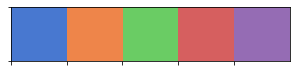

In [124]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [125]:
columns = ['Conservative', 'Liberal', 'Moderate']
colors = {'Conservative': muted[3], 
              'Moderate': muted[4], 
               'Liberal': muted[0]}

In [33]:
plot_series_lowess(polClean, 'C1')

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1948, 2016],
         title='Would most people try to be fair?')

NameError: name 'plot_series_lowess' is not defined

In [103]:
tst = fatherPolClean and motherPolClean

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

First focus on finding the correlation between parent political party and political party of the child.
Need variables for:
1. Father's political party
- When you were growing up did your father think of himself mostly as a Democrat, as a Republican, or what? - VCF0306 (1. Democrat, 2. Indepedent, Republican, 4. Other, never voted, din't get into politics, DK (1988), 9. DK)
2. Mother's political party
- When you were growing up did your mother think of himself mostly as a Democrat, as a Republican, or what? - VCF0306 (1. Democrat, 2. Indepedent, Republican, 4. Other, never voted, din't get into politics, DK, 9. DK)
VCF0307
3. Political affiliation
- Major party thermometer: VCF0291 (2. Most Republican, 50. Neutral, 99. Most Democratic)
- Genereally speaking, do you usually think of yourself as Republican, a Democrat, an Independent, or what? Do you think of yourself as closer to the Republican or Demucratic party? VCF0301 (1. Strong Democrat, 2. Weak Democrat, 3. Independent - Democrat, 4. Independent -  Independent, 5. Independent - Republican, 6. Weak Republican, 7. Strong Republican, 0. NA)
4. Respondent gender - VCF0104 (1 - male, 2 -female, 3 - other, 0 - NA, INAP - question not used), Weight: VCF0009x/VCF0009y/VCF0009z

In [69]:

motherPol = df['VCF0307']


In [71]:
pol = df['VCF0301']


If both parents were democrat, what is child? If both parenths were republican, what is child?

Need to verify data

Clean notes

Questions:
* Should I be doing any sort of weighting?

1. Father's Political Interest
- "Do you remember when you were growing up whether your father was very much interested in politics, somewhat interested, or didn't he pay much attention to it?" (1. Didn't pay much attention, 2. Somewhat interested, 3. Very much interested / 9. DK, 0. NA, INAP no question not worn)
- VCF0308
2. Mother's Political Interest
- "Now how about your mother? When you were growing up was she very much interested in politics, somewhat interested, or didn't he pay much attention to it?" (1. Didn't pay much attention, 2. Somewhat interested, 3. Very much interested / 9. DK, 0. NA, INAP no question not worn)
- VCF0309
3. Your Political Interest
- "Some people don't pay much attention to political campaigns. How about you, would you say that you have been/were very much interested, somewhat interested, or not much interested in political campaigns this year?" (1. Didn't pay much attention, 2. Somewhat interested, 3. Very much interested / 9. DK, 0. NA, INAP no question not worn)
- VCF0310 


Feeling Thermeter Political Parties:

Democrats:
* 00-96 Degrees as coded
* 97-1000 Degrees
* 98 - DK (exc. 1964-1968: see VCF0201 note)
* 99 - NA (1972)
* INAP - question not used

Weight: VCF0009x/VCF0009y/VCF0009z

pg. 90

Republicans:

In [72]:
## Goals
* 

## Topics to explore: 
* How likely are people to stick with their parents' political alignment? 
* If one of your parents is a democrat, and the other is a republican, does that make you more likely to be apolitical, a centrist, or pick one or the other? If you are going to pick one or the other, which one is more likely to be picked? What trends are there if any? 
* Does more politically active parents lead to more politically active children?
* How likely are you to have political views that align with your parents political party?
* Is there a correlation between socio-economic class and political involvement?

## Variables:
* “Feeling thermometer” variables (e.g. policemen, political parties, people on welfare, feminists, people seeking to protect the environment”
* “Women’s equal role” - Should women have equal role in the household as the man (7-pt scale)?
* “During the past 12 months, have you worked with other people to deal with some issues facing your community?”
* “Did you give any money to a political party this year?”
* “Some people don’t pay much attention to political campaigns…”
* “Do you remember when you were growing up whether your  father was very much interested in politics, somewhat interested , or he didn’t pay much attention?”
* Same as above but for mothers
* “Did your father participate in elections?”
* Same as above but for mothers
* Did you give any money to a political party this year?

## To Do 
* Download data
* [Load data](https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_stata.html?highlight=dta)
* Learn about weighting
* Load variables

SyntaxError: invalid syntax (<ipython-input-72-ffd792c541a1>, line 2)